In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import rankdata
import statsmodels.api as sm
from hw6_starter import *

## Functions for DP Percentile Release

In [211]:
def dp_percentile(x, n, B, t, epsilon):
    target = n * t / 100
    x_sorted = np.sort(x)
    if (x_sorted[0] != 0):
        x_sorted = np.insert(x_sorted, 0, 0)
        target += 1
    if (x_sorted[len(x_sorted) - 1] != B):
        x_sorted = np.append(x_sorted, np.array(B))
    
    # score each candidate (can be more computationally efficient to score all at once)
    scores = score_percentile(len(x_sorted), target)
    # print(target)
    # print(scores)
    # for numerical stability; omitting this line results in the same probabilities
    scores -= scores.max()

    # compute likelihood of selecting each candidate
    likelihoods = np.exp(epsilon * scores / 2)
    for i in range(len(likelihoods)):
        if (i < target):
            likelihoods[i] *= x_sorted[i + 1] - x_sorted[i]
        elif (i == target):
            likelihoods[i] = 0;
        elif (i > target):
            likelihoods[i] *= x_sorted[i] - x_sorted[i - 1]

    # normalize to a probability
    probabilities = likelihoods / likelihoods.sum()

    # select one candidate range wrt the selection probabilities
    index = np.random.choice(a=range(len(x_sorted)), p=probabilities)                         
    lower = index
    upper = index + 1
    if (index > target):
        lower -= 1
        upper -= 1
    
    # return a random value from the selected range
    return np.random.uniform(x_sorted[lower], x_sorted[upper])
                             

def score_percentile(n, target):
    """Scores a candidate based on proximity to the median."""
    return np.array([n - abs(i - target) for i in range(n)])

def rmse(answers, exact):
    return np.sqrt(((answers - exact) ** 2).mean())

In [212]:
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = np.array(data)
dp_percentile(data, 10, 11, 1, 1)

0.9789230163243368

In [213]:
def dp_winsorized(x, n, B, epsilon):
    x_clip = np.clip(x, 0, B)
    lower_perc = dp_percentile(x_clip, n, B, 5, epsilon / 3)
    upper_perc = dp_percentile(x_clip, n, B, 95, epsilon / 3)
    clipped_mean = np.mean(np.clip(x, lower_perc, upper_perc))
    return clipped_mean + np.random.laplace(0, 3 * (upper_perc - lower_perc) / (epsilon * n))

def dp_mean(x, B, epsilon):
    return np.clip(np.mean(np.clip(x, 0, B)) + np.random.laplace(0, B / (epsilon * n)), 0, B)

In [214]:
full_data = pd.read_csv("FultonPUMS5full.csv")
pumas = full_data["puma"].unique()
incomes = []
for puma in pumas:
    incomes.append(full_data[full_data["puma"] == puma]["income"].values)
true_means = [np.mean(income) for income in incomes]
    
num_trials = 100
columns = ["puma", "winsorized", "laplace"]
epsilon = 1
B_list = [5 * (10 ** 5), 5 * (10 ** 6), 5 * (10 ** 7)]
histories = []
rmses = [[], []]
for B in B_list:
    rows = []
    results = []
    for i in tqdm(range(len(pumas))):
        cur_inc = incomes[i]
        n = len(cur_inc)
        for j in range(num_trials):
            winsor = dp_winsorized(cur_inc, n, B, epsilon)
            laplace = dp_mean(cur_inc, B, epsilon)
            rows.append([pumas[i], winsor, laplace])
            results.append([true_means[i], winsor, laplace])
    histories.append(pd.DataFrame(rows, columns=columns))
    results = np.array(results).T
    rmses[0].append(rmse(results[0], results[1]))
    rmses[1].append(rmse(results[0], results[2]))

100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


## Run DP Median Experiments

winsor RMSE: 3376.331730911598
laplace RMSE: 206.42084983891542


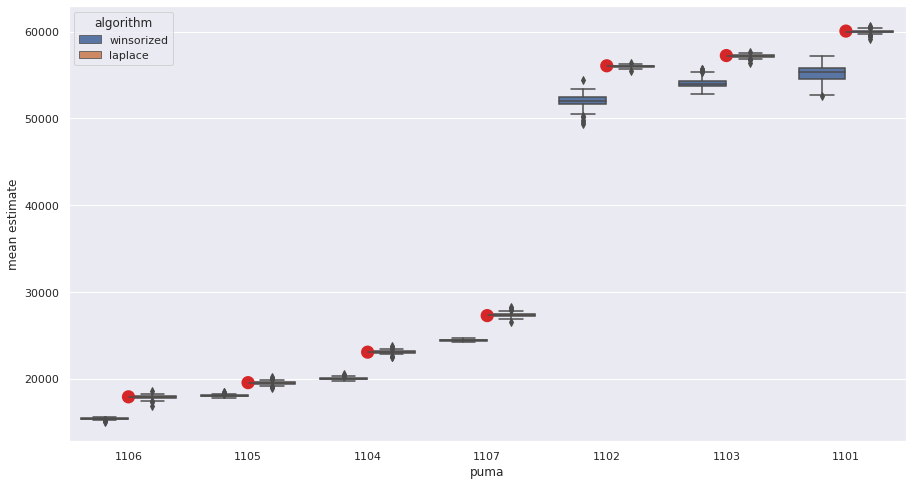

In [215]:
print("winsor RMSE:", rmses[0][0])
print("laplace RMSE:", rmses[1][0])
build_boxplot(full_data, "income", histories[0], columns[1:3])

winsor RMSE: 3437.7524116557975
laplace RMSE: 2011.8682861372693


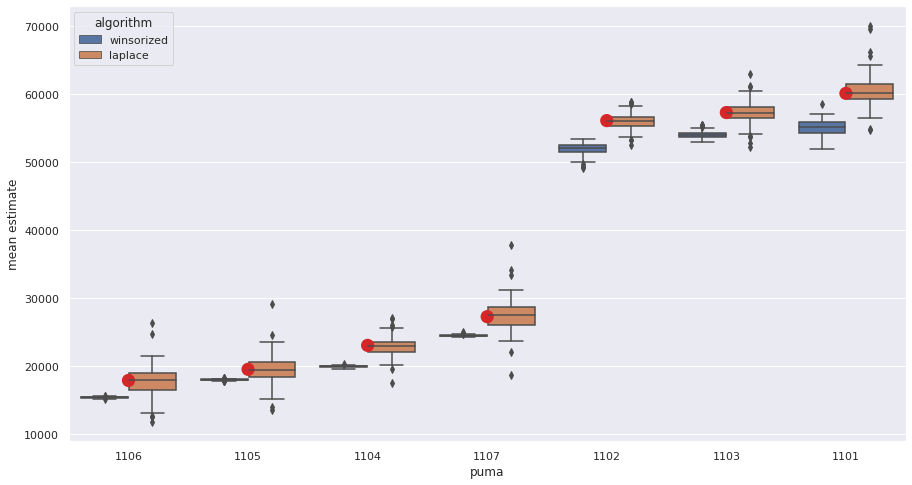

In [216]:
print("winsor RMSE:", rmses[0][1])
print("laplace RMSE:", rmses[1][1])
build_boxplot(full_data, "income", histories[1], columns[1:3])

winsor RMSE: 3407.448478017587
laplace RMSE: 19611.037524759045


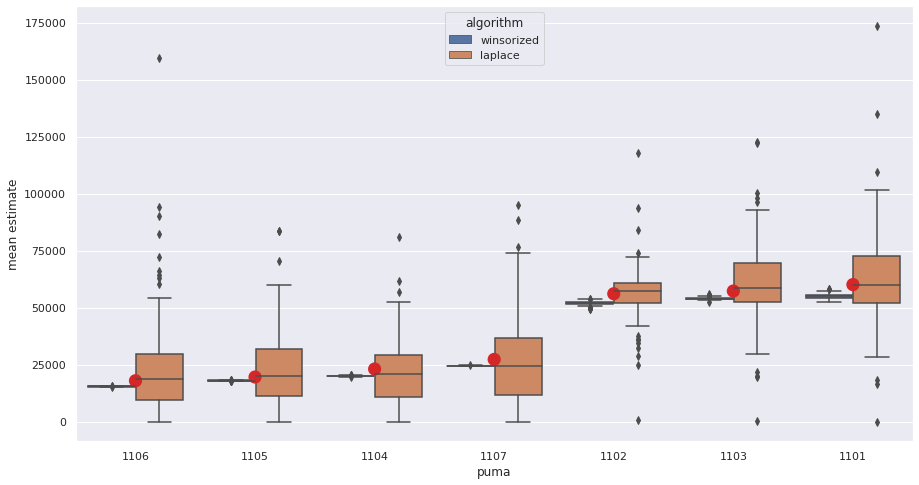

In [217]:
print("winsor RMSE:", rmses[0][2])
print("laplace RMSE:", rmses[1][2])
build_boxplot(full_data, "income", histories[2], columns[1:3])